In [1]:
# HW09 -- Projective Reconstruction
# Author: Ran Xu (xu943@purdue.edu)

# Manual selection of 8 key points on both image
import numpy as np
img1_name, img2_name = ("s1", "s2")
KPL = np.array([[156, 1845,1422,2853,483 ,1386,2532,1671],   # X cord. (--)
                [1464,288, 2337,741, 2214,2901,1506,1197],   # Y cord. (|)
                [1,   1,   1,   1,   1,   1,   1,   1]])     # HC: all ones
KPR = np.array([[195, 2124,714, 2874,447, 870 ,2556,1485],   # X cord. (--)
                [1203,639, 2100,1200,1974,2757,1917,1305],   # Y cord. (|)
                [1,   1,   1,   1,   1,   1,   1,   1]])     # HC: all ones
KPL[0:2, :] = KPL[0:2, :]/7.875
KPR[0:2, :] = KPR[0:2, :]/7.875

In [2]:
import cv2 as cv
# Unit test -- read image
img1 = cv.imread("%s.jpg" %img1_name)
img2 = cv.imread("%s.jpg" %img2_name)
print("Image shapes (H, W, C) = ", img1.shape, img2.shape)

('Image shapes (H, W, C) = ', (512, 384, 3), (512, 384, 3))


In [5]:
def Solve_F(KPL, KPR):  # KPL/KPR is (3,n) shape, third row must be 1
    Npts = KPL.shape[1]
    A = np.zeros((Npts, 9))
    for idx in range(Npts):
        A[idx, 0] = KPR[0, idx]*KPL[0, idx] # x' * x
        A[idx, 1] = KPR[0, idx]*KPL[1, idx] # x' * y
        A[idx, 2] = KPR[0, idx]             # x' * 1
        A[idx, 3] = KPR[1, idx]*KPL[0, idx] # y' * x
        A[idx, 4] = KPR[1, idx]*KPL[1, idx] # y' * y
        A[idx, 5] = KPR[1, idx]             # y' * 1
        A[idx, 6] = KPL[0, idx]             # x
        A[idx, 7] = KPL[1, idx]             # y
        A[idx, 8] = 1                       # 1
    # Solve F
    u, s, vh = np.linalg.svd(A)
    f = vh[-1, :]   # The eigenvector corresponding to the smallest eigen value
    F = np.array([[f[0], f[1], f[2]], [f[3], f[4], f[5]], [f[6], f[7], f[8]]])/f[8]
    # Enforce F to be rank 2
    u, s, vh = np.linalg.svd(F)
    s[-1] = 0
    F = np.dot(np.dot(u, np.diag(s)), vh)
    LeftNull = u[:, 2]
    return F, LeftNull

import scipy.optimize
def LossFunc(p, KPL, KPR, F, PL):  # Shapes: (12), (3,N)
    PR = p[0:12].reshape(3,4)
    Npts = int(p.shape[0]-12)/3
    X = np.vstack([p[12:].reshape(3, Npts), np.ones((1, Npts))])  
    
    # Compute Error
    Est_KPL = np.dot(PL, X)
    Est_KPL = Est_KPL/Est_KPL[2,:]
    Est_KPR = np.dot(PR, X)
    Est_KPR = Est_KPR/Est_KPR[2,:]
    DiffL = Est_KPL - KPL
    DiffR = Est_KPR - KPR
    Diff = np.hstack([DiffL.flatten(), DiffR.flatten()])
    Cost = np.sum(Diff**2)/2
    return Diff

def PrintKP(img_name, KP, prefix): # Print the 8 key pts on images and label with "A" to "H" 
    # img is (H, W, 3), KP is (3, 8) shape
    KP2D = KP[0:2,:]/KP[2,:]
    img = cv.imread('%s.jpg' %img_name)
    Labels = ["A", "B", "C", "D", "E", "F", "G", "H"]
    for idx in range(8):
        # Draw key points: KP2D[0, idx], KP2D[1, idx]
        x_kp = KP2D[0, idx]
        y_kp = KP2D[1, idx]
        cv.circle(img, center = (int(x_kp), int(y_kp)), radius = 3, color = (0, 0, 255))
        # Draw labels: Labels[idx]
        cv.putText(img, Labels[idx], (int(x_kp+3), int(y_kp+3)), 
                  cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    cv.imwrite('save_8kp_%s_%s.jpg' %(prefix,img_name), img)

In [10]:
PrintKP(img1_name, KPL, "Init")
PrintKP(img2_name, KPR, "Init")
F, eR = Solve_F(KPL, KPR)  # (3,3), (3,)
print("F=", F)

# Solve P, P' with F, eR
PL = np.array([[1,0,0,0], [0,1,0,0], [0,0,1,0]])  # [I_3x3, 0] 
eRx = np.array([[0, -eR[2], eR[1]], [eR[2], 0, -eR[0]], [-eR[1], eR[0], 0]])
PR = np.hstack([np.dot(eRx, F), eR.reshape(3,1)]) # [e']xF | e'

# Estimate X
Npts = KPL.shape[1]
X = np.zeros((4, Npts))
for idx in range(Npts):
    xL, yL = (KPL[0, idx], KPL[1, idx])
    xR, yR = (KPR[0, idx], KPR[1, idx])
    A = np.zeros((4, 4))
    A[0, :] = xL * PL[2, :] - PL[0, :]
    A[1, :] = yL * PL[2, :] - PL[1, :]
    A[2, :] = xR * PR[2, :] - PR[0, :]
    A[3, :] = yR * PR[2, :] - PR[1, :]
    u, s, vh = np.linalg.svd(A)
    X[:, idx] = vh[-1, :]/vh[-1, -1]

# PreLM
Est_KPL = np.dot(PL, X)
Est_KPR = np.dot(PR, X)
PrintKP(img1_name, Est_KPL, "PreLM")
PrintKP(img2_name, Est_KPR, "PreLM")

p_init = np.hstack([PR.flatten(), X[0:3,:].flatten()])
Diff = LossFunc(p_init, KPL, KPR, F, PL); Cost = np.sum(Diff**2)/2
print("LM optimization starts! Initial Cost = %.5f" %Cost)

# PostLM
sol = scipy.optimize.least_squares(LossFunc, p_init, method = 'lm', args = [KPL, KPR, F, PL])
Diff = LossFunc(sol.x, KPL, KPR, F, PL); Cost = np.sum(Diff**2)/2
print("LM optimization ends! Initial Cost = %.5f" %Cost)

p = sol.x
PR = p[0:12].reshape(3,4)
Npts = int(p.shape[0]-12)/3
X = np.vstack([p[12:].reshape(3, Npts), np.ones((1, Npts))])  
Est_KPL = np.dot(PL, X)
Est_KPR = np.dot(PR, X)
PrintKP(img1_name, Est_KPL, "PostLM")
PrintKP(img2_name, Est_KPR, "PostLM")

('F=', array([[ 7.517e-06, -7.874e-05, -4.477e-02],
       [ 1.176e-05, -4.923e-05,  1.497e-01],
       [ 1.360e-02, -1.148e-01,  1.000e+00]]))
LM optimization starts! Initial Cost = 1.37372
LM optimization ends! Initial Cost = 0.00515


In [7]:
# 3D print
Est_KPL = Est_KPL/Est_KPL[2,:]
Est_KPR = Est_KPR/Est_KPR[2,:]
np.set_printoptions(3)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

lines = [[1, 2], [1, 3], [3, 4], [2, 4], [1, 5], [3, 6], [5, 6], [6, 7], [4, 7]]
fig = plt.figure(figsize=(10,6))
ax = fig.gca(projection='3d')
Labels = ["A", "B", "C", "D", "E", "F", "G", "H"]

for idx in range(8):
    plt.scatter(X[0,idx], X[1,idx], X[2,idx])
    ax.text(X[0,idx], -X[1,idx], -X[2,idx], Labels[idx], zdir = None)
for line in lines:
    Xs = [X[0, idx-1] for idx in line]
    Ys = [-X[1, idx-1] for idx in line] # Rotate y so that it matches original direction
    Zs = [-X[2, idx-1] for idx in line] # Rotate z so that it matches original direction
    plt.plot(Xs, Ys, Zs)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.savefig("Recon3D.png")
ax.view_init(azim=-70)

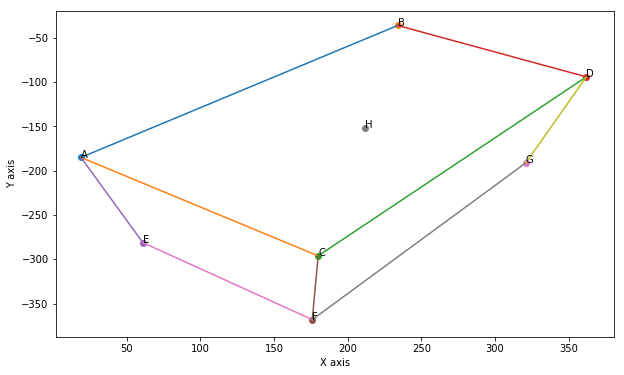

In [8]:
#plt.plot([X[0,0], X[0,1]], [X[1,0], X[1,1]])  # 0--> 1
#plt.plot([X[0,0], X[0,2]], [X[1,0], X[1,2]])  # 0--> 2

X2D = X[0:2, :]/X[2:3,:]
fig = plt.figure(figsize=(10,6))
for idx in range(8):
    plt.scatter(X2D[0,idx], -X2D[1,idx])
    plt.text(X2D[0,idx], -X2D[1,idx], Labels[idx]) # Rotate y so that it matches original direction
for line in lines:
    Xs = [X2D[0, idx-1] for idx in line]
    Ys = [-X2D[1, idx-1] for idx in line] # Rotate y so that it matches original direction
    plt.plot(Xs, Ys)
ax = fig.gca()
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
plt.savefig("Recon2D_Left.png")

In [9]:
def SSD(f1, f2):
    return np.sum((f1-f2)**2)

def KPDist(KP1, KP2, F, th = 3): # (3,1), (3,1), (3,3)
    # Epipolar line in image 2
    KPL = np.array([[KP1[0]], [KP1[1]], [1]])
    KPR = np.array([[KP2[0]], [KP2[1]], [1]])
    EpiLineR = np.dot(F, KPL)
    Dist = np.dot(EpiLineR.reshape(1,3), KPR)/np.sqrt(EpiLineR[0]**2+EpiLineR[1]**2)
    return np.abs(Dist[0][0]) > th

def Correspondence_Dist(FM1, Coord1, FM2, Coord2, F): 
    #(#,128), [i].pt=(2,), (##,128), [i].pt=(2,)
    N1 = FM1.shape[0]
    N2 = FM2.shape[0]
    Pairs = []
    Scores = []
    for idx1 in range(N1):
        Score = np.array([SSD(FM1[idx1,:], FM2[idx2,:]) for idx2 in range(N2)])
        OutRange = [KPDist(Coord1[idx1].pt, Coord2[idx2].pt, F, th = 3) for idx2 in range(N2)]
        Score = [x+1e10*y for (x,y) in zip(Score, OutRange)]
        idx2 = np.argmin(Score)
        Scores.append(np.min(Score))
        Pairs.append((idx1,idx2))
    BestPairs = [x for _,x in sorted(zip(Scores,Pairs))]  # Incresing order
    # Select 15 pairs
    return BestPairs[0:int(np.min([15,len(BestPairs)]))] 

def Correspondence(FM1, Coord1, FM2, Coord2): 
    #(#,128), [i].pt=(2,), (##,128), [i].pt=(2,)
    N1 = FM1.shape[0]
    N2 = FM2.shape[0]
    Pairs = []
    Scores = []
    for idx1 in range(N1):
        Score = np.array([SSD(FM1[idx1,:], FM2[idx2,:]) for idx2 in range(N2)])
        idx2 = np.argmin(Score)
        Scores.append(np.min(Score))
        Pairs.append((idx1,idx2))
    BestPairs = [x for _,x in sorted(zip(Scores,Pairs))]  # Incresing order
    # Select 15 pairs
    return BestPairs[0:int(np.min([15,len(BestPairs)]))] 

def DrawPairs(input_image1, input_image2, Coord1, Coord2, Pairs, prefix):
    left = cv.imread("%s.jpg" %input_image1)
    right = cv.imread("%s.jpg" %input_image2)
    output = np.concatenate((left, right), axis = 1)
    for (idx1, idx2) in Pairs:
        x1 = int(Coord1[idx1].pt[0])
        y1 = int(Coord1[idx1].pt[1])
        x2 = int(Coord2[idx2].pt[0]) + left.shape[1]
        y2 = int(Coord2[idx2].pt[1])
        cv.line(output, (x1,y1),(x2,y2), (255,255,0), 2)
    cv.imwrite("%sRect_%s_%s.png" %(prefix, input_image1, input_image2), output)

# Unit test -- read image, get SIFT KPs, and draw
sift = cv.xfeatures2d.SIFT_create()

img = cv.imread('%s.jpg' %img1_name)
img1_gray = cv.imread('%s.jpg' %img1_name, cv.IMREAD_GRAYSCALE)
kp1, des1 = sift.detectAndCompute(img1_gray, None)
cv.drawKeypoints(img,kp1,img)
cv.imwrite('KP_%s.jpg' %img1_name, img)

img = cv.imread('%s.jpg' %img2_name)
img2_gray = cv.imread('%s.jpg' %img2_name, cv.IMREAD_GRAYSCALE)
kp2, des2 = sift.detectAndCompute(img2_gray, None)
cv.drawKeypoints(img,kp2,img)
cv.imwrite('KP_%s.jpg' %img2_name, img)

Pairs = Correspondence(des1, kp1, des2, kp2)
DrawPairs(img1_name, img2_name, kp1, kp2, Pairs, "Pre")
Pairs = Correspondence_Dist(des1, kp1, des2, kp2, F)
DrawPairs(img1_name, img2_name, kp1, kp2, Pairs, "Post")